exp_filter_norotate.ipynb

Author: Anderson Steckler

Filters the backscatter points from experimental data and plots wavefronts,
rotates DK points instead of image

INPUT: Flattened STM data as ASCII XYZ text file. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage import rotate

In [2]:
pth = r"Data/STM_Device 115_g 10K_2019_10_11_17_03_18_195 Image Topography.txt"
df = pd.read_table(pth, skiprows=3, sep='\t', header=None, names=['X', 'Y', 'Z'])
df.head()

,X,Y,Z
0,0.000000,0.0,0.000000e+00
1,0.058870,0.0,8.690110e-12
2,0.117741,0.0,1.938070e-11
3,0.176611,0.0,2.564060e-11
4,0.235481,0.0,2.610520e-11


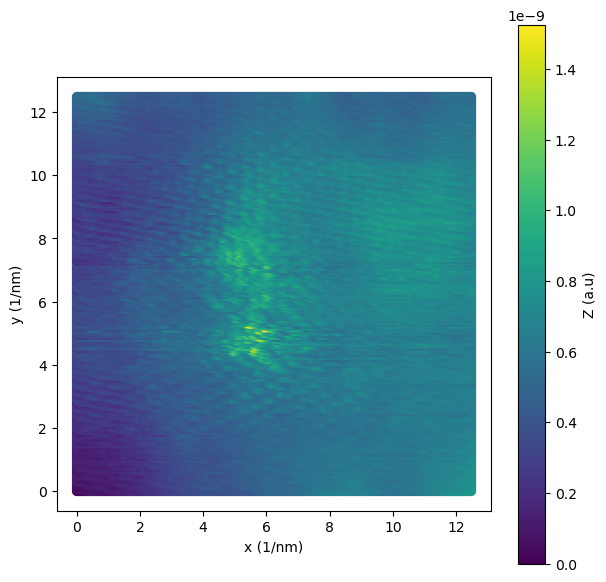

In [3]:
fig1, ax1 = plt.subplots(figsize=(7, 7))

sc1 = ax1.scatter(df['X'], df['Y'], c=df['Z'])
cb1 = plt.colorbar(sc1, ax=ax1)
cb1.set_label('Z (a.u)')
ax1.set_xlabel("x (1/nm)")
ax1.set_ylabel("y (1/nm)")
ax1.set_aspect("equal")

In [4]:
# Turn into matrix CGPT
ux, uy = np.unique(df['X']), np.unique(df['Y'])

z = np.zeros((len(ux), len(uy)))

for i, x in enumerate(ux):
    for j, y in enumerate(uy):
        index = np.where((df['X'] == x) & (df['Y'] == y))[0][0]
        z[j, i] = df['Z'][index]

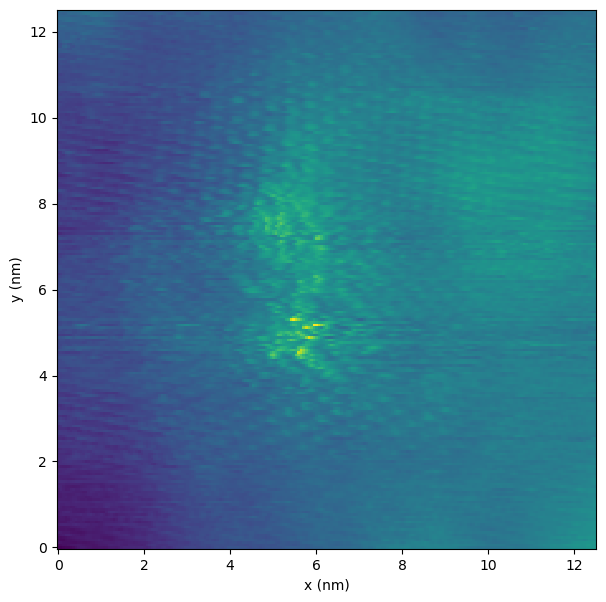

In [5]:
fig2, ax2 = plt.subplots(figsize=(7, 7))

ax2.pcolormesh(ux, uy, z)
ax2.set_xlabel("x (nm)")
ax2.set_ylabel("y (nm)")
ax2.set_aspect("equal")

In [6]:
ftz = np.fft.fft2(z)
ftz = np.fft.fftshift(ftz)
plz = np.log(np.abs(ftz ** 2))

In [7]:
# Answering Question: Are these values evenly spaced??
dx = np.array([ux[i+1] - ux[i] for i in range(0, len(ux)-1)])
dy = np.array([uy[i+1] - uy[i] for i in range(0, len(uy)-1)])

dxm = np.average(dx)
dym = np.average(dy)

print(dx[0:20])
print(np.average(dx), np.std(dx))
print("")
print(dy[0:20])
print(np.average(dy), np.std(dy))

[0.05887  0.058871 0.05887  0.05887  0.05887  0.058871 0.05887  0.05887
 0.058871 0.05887  0.05887  0.05887  0.058871 0.05887  0.05887  0.058871
 0.05887  0.05887  0.05887  0.058871]
0.058870283018867924 4.50465524012311e-07

[0.05887  0.058871 0.05887  0.05887  0.05887  0.058871 0.05887  0.05887
 0.058871 0.05887  0.05887  0.05887  0.058871 0.05887  0.05887  0.058871
 0.05887  0.05887  0.05887  0.058871]
0.058870283018867924 4.50465524012311e-07


In [11]:
# Degrees
def rotate2D(x, y, theta):
    theta = np.deg2rad(theta)
    a = x * np.cos(theta) - y * np.sin(theta)
    b = x * np.sin(theta) + y * np.cos(theta)

    return np.array([a, b])

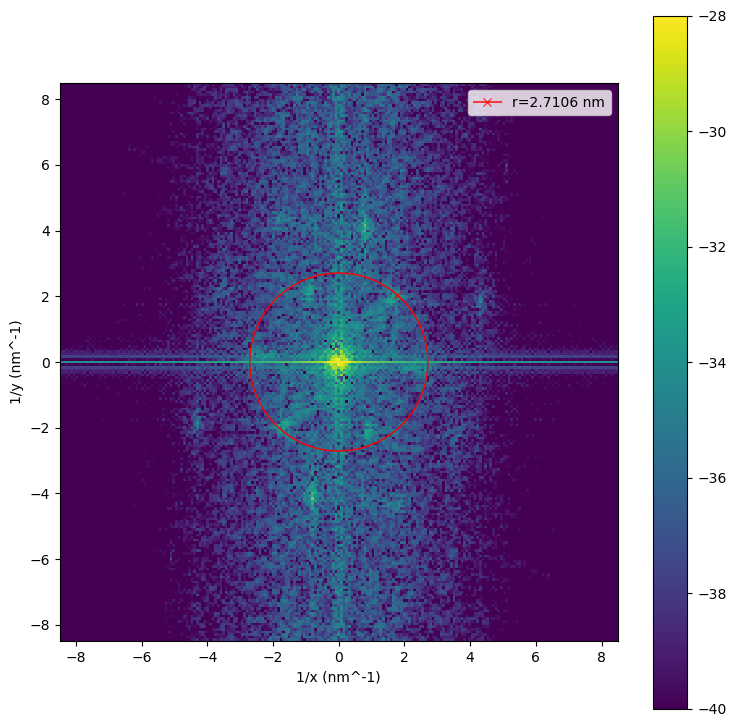

In [177]:
fig3, ax3 = plt.subplots(figsize=(9, 9))

# Frequency Points
fx = np.fft.fftfreq(len(ux), dxm)
fy = np.fft.fftfreq(len(uy), dym)
fxs = np.fft.fftshift(fx)
fys = np.fft.fftshift(fy)

# Backscatter point
# From liu
acc=0.142 #nm
deltaKx = 4 * np.pi / (3 * np.sqrt(3) * acc) * 1/(2 * np.pi)
#dKR_x = 0.5 * deltaKx #rotate 60 degrees
#dKR_y = np.sqrt(3)/2 * deltaKx #rotate 60 degrees
dKR_x, dKR_y = rotate2D(deltaKx, 0, 49)

crc5 = plt.Circle((0, 0), deltaKx, color='red', fill=False)

pc = ax3.pcolormesh(fxs, fys, plz, vmin=-40, vmax=-28)
fig3.colorbar(pc)
ax3.plot(dKR_x, dKR_y, marker='x', color='red', alpha=0.7)
ax3.add_patch(crc5)

ax3.legend([f"r={deltaKx:.4f} nm"])
ax3.set_xlabel("1/x (nm^-1)")
ax3.set_ylabel("1/y (nm^-1)")
ax3.set_aspect("equal")

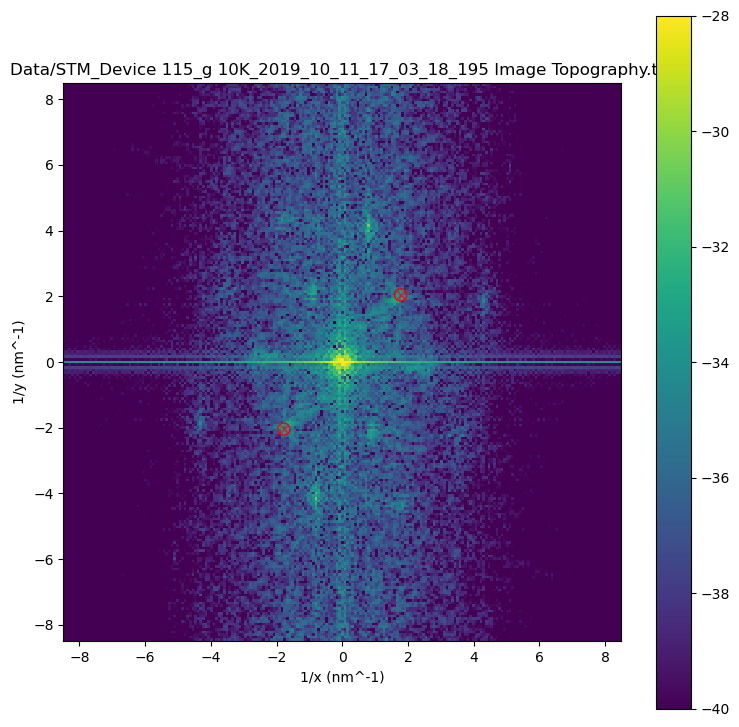

In [178]:
fig6, ax6 = plt.subplots(figsize=(9, 9))

pc = ax6.pcolormesh(fxs, fys, plz, vmin=-40, vmax=-28)
fig6.colorbar(pc)
ax6.plot(dKR_x, dKR_y, marker='x', color='red', alpha=0.7)
ax6.plot(-dKR_x, -dKR_y, marker='x', color='red', alpha=0.7)

rad = 0.37 * 0.5
crc3 = plt.Circle((dKR_x, dKR_y), rad, color='red', fill=False)
crc4 = plt.Circle((-dKR_x, -dKR_y), rad, color='red', fill=False)

ax6.add_patch(crc3)
ax6.add_patch(crc4)

ax6.set_xlabel("1/x (nm^-1)")
ax6.set_ylabel("1/y (nm^-1)")
ax6.set_title(pth)
ax6.set_aspect("equal")

In [179]:
# Periodic 1D Hann Function
def hann1dp(x, N, x0):
    return np.cos(np.pi * (x-x0)/N) ** 2

def hann2d(x, y, Nx, Ny, x0, y0): 
    val = hann1dp(x, Nx, x0) * hann1dp(y, Ny, y0)

    return np.where((np.abs(x-x0) <= 0.5 * Nx) & (np.abs(y-y0) <= 0.5 * Ny), val, 0)

hann_vec = np.vectorize(hann2d)

In [180]:
# Han Filtering
ffx, ffy = np.meshgrid(fxs, fys)
hann_z = hann2d(ffx, ffy, 2 * rad, 2 * rad, dKR_x, dKR_y) + hann2d(ffx, ffy, 2 * rad, 2 * rad, -dKR_x, -dKR_y) 

ftzf = ftz * hann_z

In [181]:
# Circle Filtering
#ffx, ffy = np.meshgrid(fxs, fys)

#dist = np.sqrt((ffx - dKR_x) ** 2 + (ffy - dKR_y) ** 2)
#mask = dist >= rad

#dist2 =  np.sqrt((ffx + dKR_x) ** 2 + (ffy + dKR_y) ** 2)
#mask2 = dist2 >= rad

#ftzf = np.where(mask, 0, ftz) + np.where(mask2, 0, ftz)

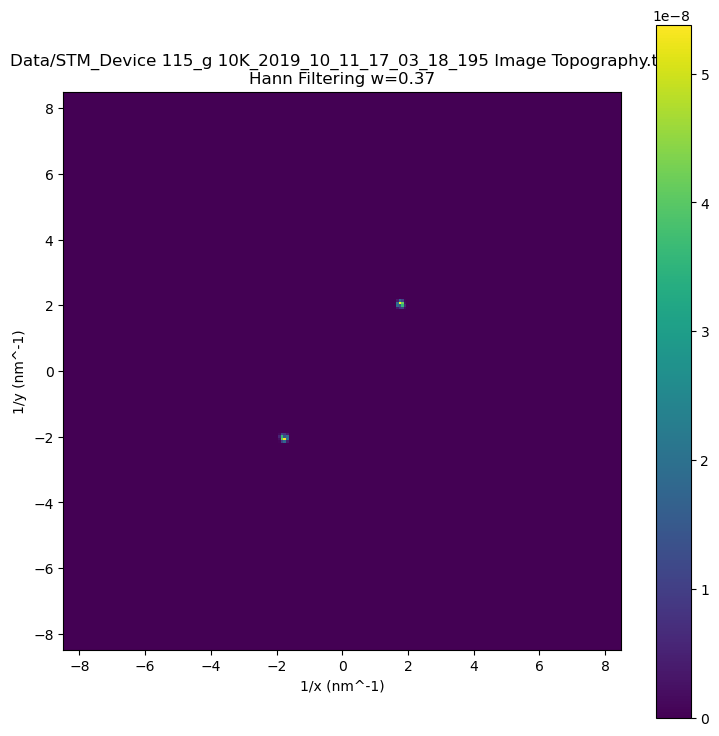

In [182]:
fig7, ax7 = plt.subplots(figsize=(9, 9))

pc = ax7.pcolormesh(fxs, fys, np.abs(ftzf))
fig7.colorbar(pc)

ax7.set_xlabel("1/x (nm^-1)")
ax7.set_ylabel("1/y (nm^-1)")
ax7.set_title(pth + "\n" + f"Hann Filtering w={rad*2:.2f}")
ax7.set_aspect("equal")

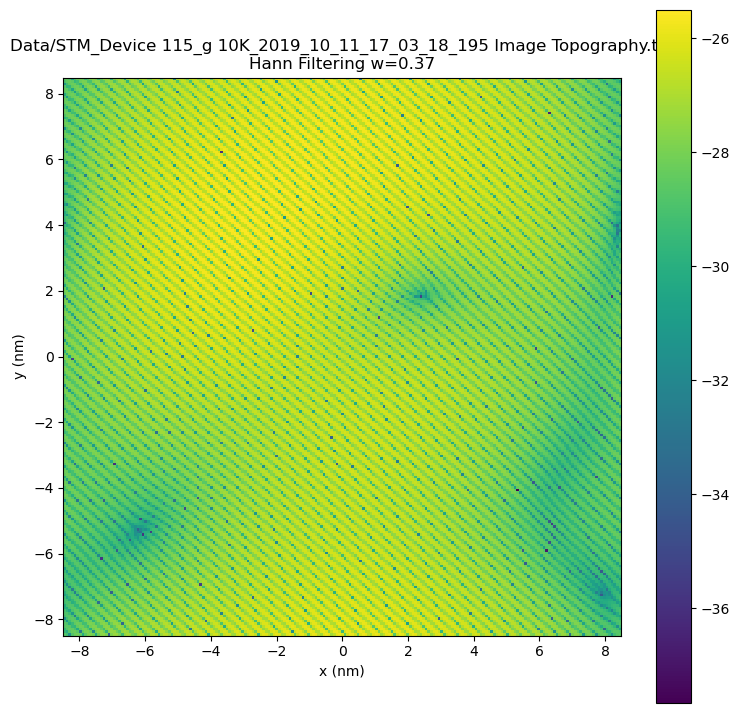

In [183]:
z_filtered = np.fft.ifft2(ftzf)

fig8, ax8 = plt.subplots(figsize=(9, 9))

pc = ax8.pcolormesh(fxs, fys, np.log(np.abs(z_filtered)))
fig8.colorbar(pc)

ax8.set_xlabel("x (nm)")
ax8.set_ylabel("y (nm)")
#ax8.set_xlim(-4, 4)
#ax8.set_ylim(-4, 4)
ax8.set_title(pth + "\n" + f"Hann Filtering w={rad*2:.2f}")
ax8.set_aspect("equal")

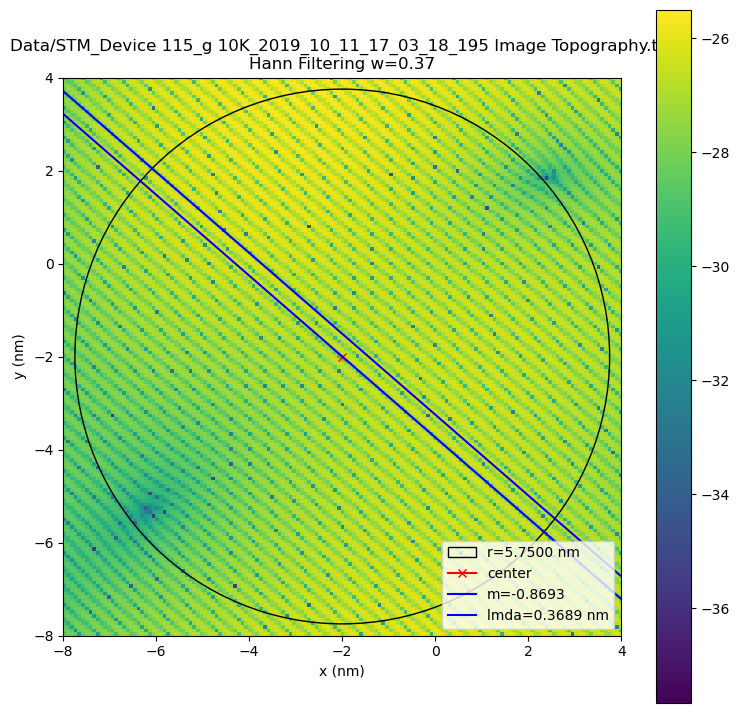

In [208]:
z_filtered = np.fft.ifft2(ftzf)

fig9, ax9 = plt.subplots(figsize=(9, 9))

pc = ax9.pcolormesh(fxs, fys, np.log(np.abs(z_filtered)))
fig9.colorbar(pc)

xc, yc = -2, -2
rc = 5.75

circ = plt.Circle((xc, yc), rc, fill=False)
ax9.add_patch(circ)
ax9.plot(xc, yc, marker='x', color='r')

# Lim
w=6
ax9.set_xlim(xc-w, xc+w)
ax9.set_ylim(yc-w, yc+w)

# plotting parallel line
m1, b1 = -dKR_x/dKR_y, 0
xlin = np.linspace(xc-w, xc+w, 100)
ax9.plot(xlin, m1 * (xlin-xc) + (b1 + yc), 'blue')

# Plotting wavelength
#wavel = 0.3689
wavel = 2 * np.pi / np.sqrt(dKR_x ** 2 + dKR_y ** 2) * 1/(np.pi * 2)
# After some geometry
b2 = (m1 ** 2 + 1)/np.sqrt(m1 ** 2 + 1) * wavel
ax9.plot(xlin, m1 * (xlin-xc) + (b2+yc), 'blue')

ax9.set_xlabel("x (nm)")
ax9.set_ylabel("y (nm)")
ax9.set_title(pth + "\n" + f"Hann Filtering w={rad*2:.2f}")
ax9.set_aspect("equal")
ax9.legend([f"r={rc:.4f} nm", "center", f"m={m1:.4f}", f"lmda={wavel:.4f} nm"], loc=4)